In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import torch
import matplotlib.pyplot as plt
from flipper_training.environment.base_env import BaseDPhysicsEnv
from flipper_training.engine.engine import DPhysicsEngine
from flipper_training.configs import *
from collections import deque
from copy import deepcopy

In [3]:
num_robots = 1

In [4]:
from flipper_training.utils.environment import make_x_y_grids, generate_heightmaps

In [5]:
# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 6.4  # meters
x_grid, y_grid = make_x_y_grids(max_coord, grid_res, num_robots)


def generate_heightmap(x, y):
    return (1.0 * torch.exp(-0.5 * ((x - 0)**2 + (y - 4)**2)) +
            0.0 * torch.exp(-0.3 * ((x - 1)**2 + (y + 2)**2)) +
            2.0 * torch.exp(-0.1 * ((x + max_coord)**2 + (y + max_coord)**2))
            ) + 0.01 * torch.randn_like(x) + torch.exp(-0.03 * ((x + 5)**2 + (y + 5)**2))


z_grid = generate_heightmaps(x_grid, y_grid, generate_heightmap)

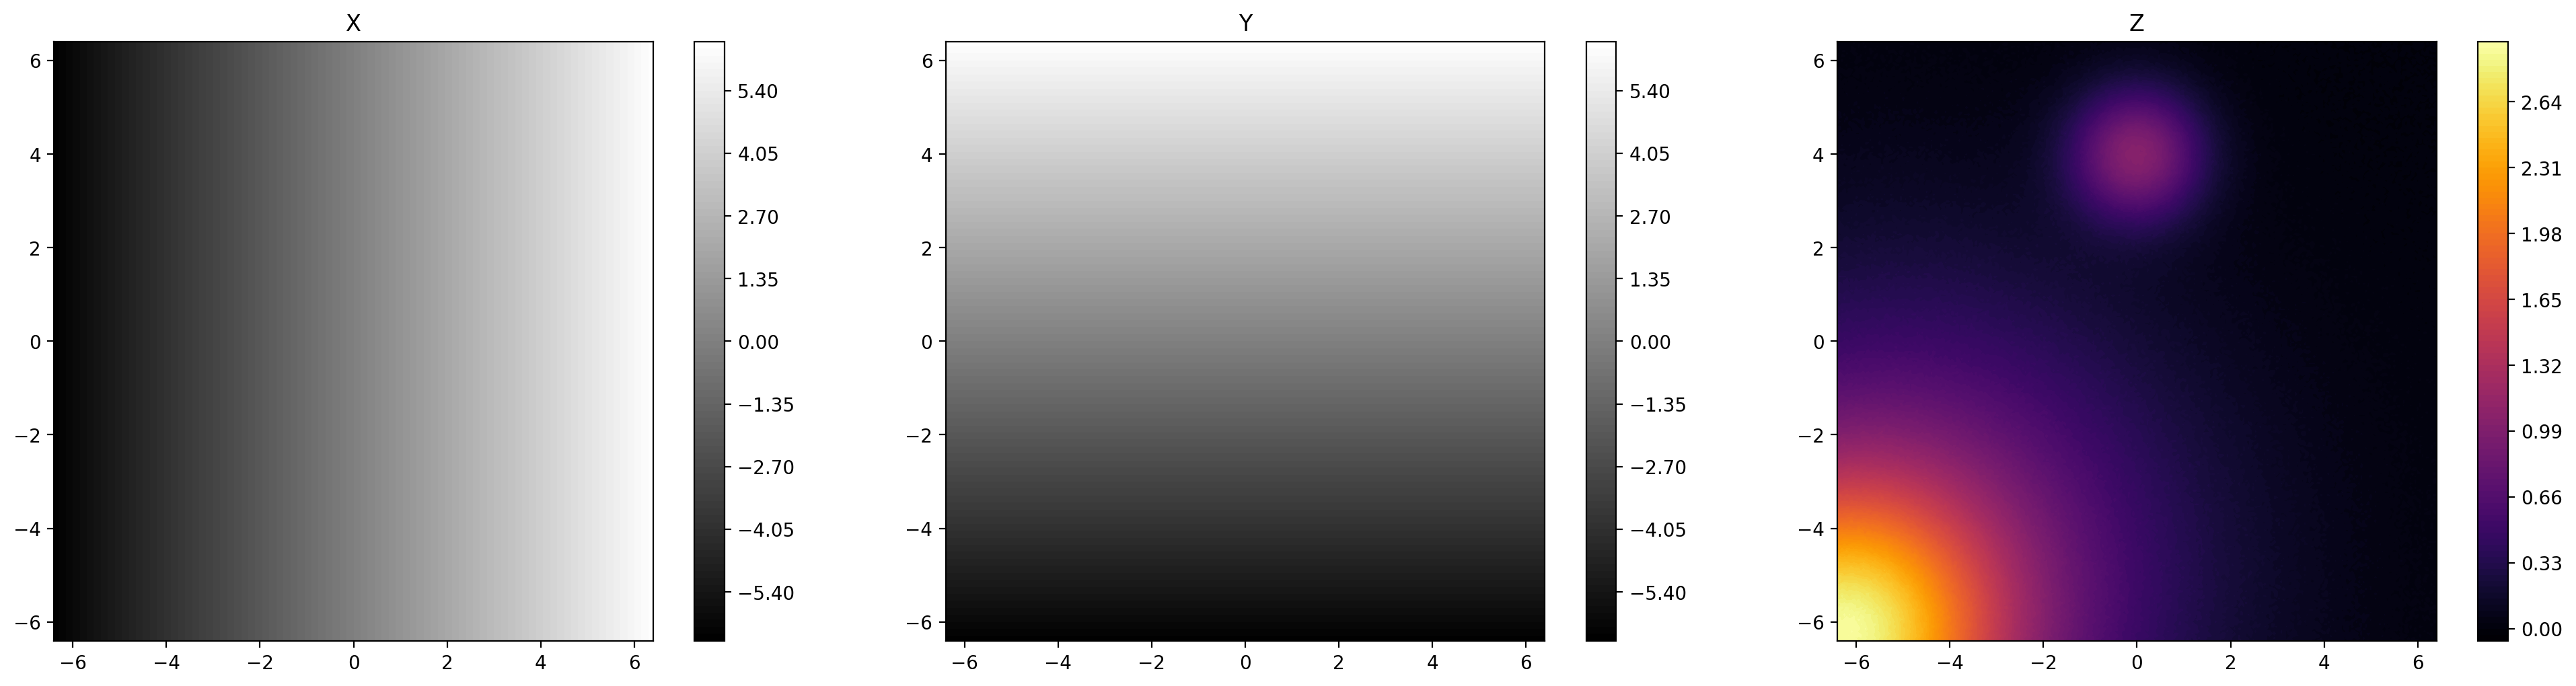

In [6]:
from flipper_training.vis.static_vis import plot_grids_xyz

plot_grids_xyz(x_grid[0], y_grid[0], z_grid[0])

In [7]:
device = "cpu"

In [8]:
# Instatiate the physics config
robot_model = RobotModelConfig(robot_type="marv", voxel_size=0.08, points_per_driving_part=150)
world_config = WorldConfig(x_grid=x_grid, y_grid=y_grid, z_grid=z_grid, grid_res=grid_res, max_coord=max_coord, k_stiffness=30000)
physics_config = PhysicsEngineConfig(num_robots=num_robots)

Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.cache/marv_0.080_150.pt


In [9]:
for cfg in [robot_model, world_config, physics_config]:
    cfg.move_all_tensors_to_device(device)

In [10]:
# Controls
traj_length = 15.0  # seconds
n_iters = int(traj_length / physics_config.dt)
speed = 1.0  # m/s forward
omega = 0.0  # rad/s yaw
flipper_controls = torch.zeros(robot_model.num_joints)
control_vec = torch.cat([torch.tensor([speed, omega]), flipper_controls]).unsqueeze(0).repeat(num_robots, 1)

In [11]:
env = BaseDPhysicsEnv(EnvConfig(), physics_config, robot_model, device)

In [12]:
from flipper_training.utils.geometry import rot_Z

In [13]:
x0 = torch.tensor([-6, -6, 2.5]).to(device).repeat(num_robots, 1)
R0 = rot_Z(torch.full((num_robots,), torch.pi / 4)).to(device)
thetas0 = torch.zeros(num_robots, 4).to(device)
env.init(x0, R0, thetas0, world_config)

In [14]:
env.compile()

In [15]:
state, obs = env.reset()

In [16]:
states = deque(maxlen=n_iters)
dstates = deque(maxlen=n_iters)
auxs = deque(maxlen=n_iters)

for i in range(n_iters):
    state, dstate, aux, obs = env.step(control_vec)
    states.append(state)
    dstates.append(dstate)
    auxs.append(aux)

<Axes: title={'center': 'Birdview of trajectory'}, xlabel='x', ylabel='y'>

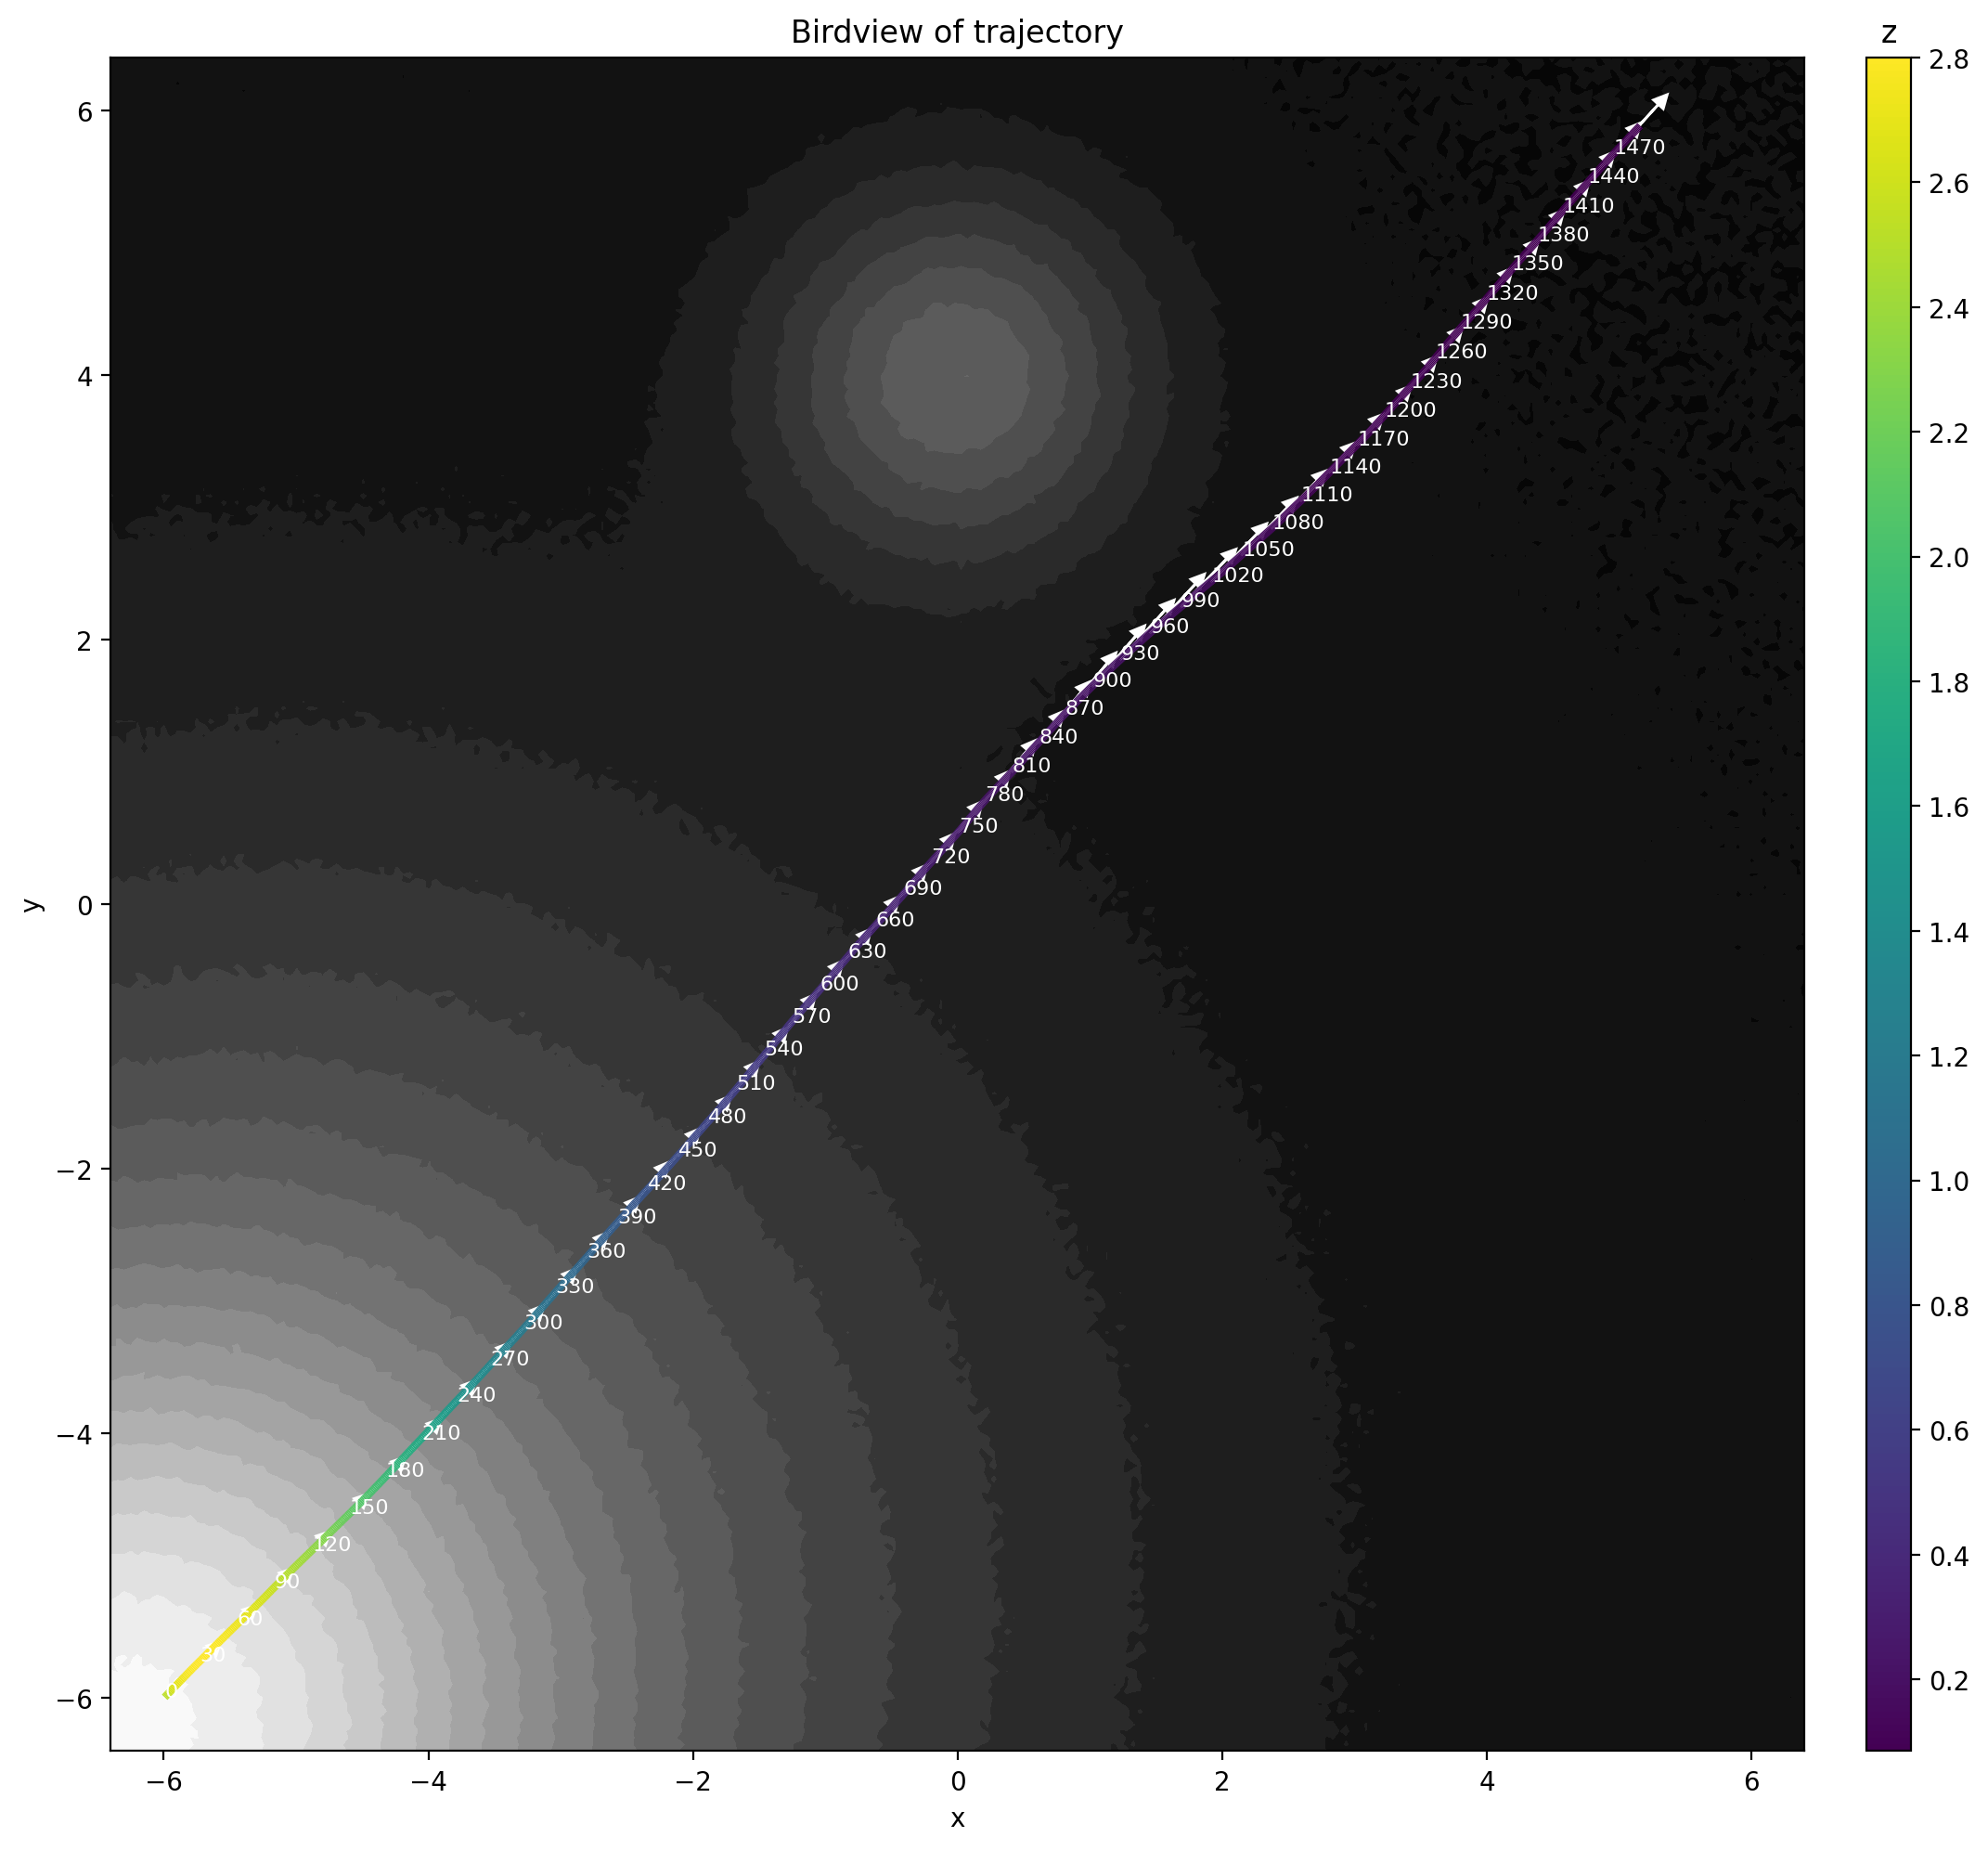

In [17]:
from flipper_training.vis.static_vis import plot_birdview_trajectory

plot_birdview_trajectory(world_config, states, 0)

In [18]:
from flipper_training.vis.animator import animate_trajectory

animate_trajectory(world_config, physics_config, states, auxs, 0)

2024-12-29 13:56:21.045 Python[34935:2328013] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/yj/_6b0pqvs5xg33v_xy5q2v9_40000gn/T/org.python.python.savedState
2024-12-29 13:56:21.295 Python[34935:2328013] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-29 13:56:21.295 Python[34935:2328013] +[IMKInputSession subclass]: chose IMKInputSession_Modern
